In [ ]:
# ======================================================
# CONDITIONAL RANDOM FIELD (CRF) MODEL FOR CPT DATA
# ======================================================
# Purpose: Predict lithostratigraphic units from CPT data using CRF
# ======================================================

In [ ]:
from pathlib import Path
from data_module import segments_oi, invalid_labels, DataSet
folder = Path(r"C:\Users\dorothy.chepkoech\Documents\MSC_2026\Project_DataScience\Data")

for p in folder.glob("*.parquet"):
    print(p.name)



raw_parquet.parquet
remapped.parquet


In [24]:
import pandas as pd
import numpy as np
from pathlib import Path

home = Path.home()
print("Home folder:", home)

# Correct path with correct spelling and folder name
path_to_parquet = home / "Documents" / "MSC_2026" / "Project_DataScience" / "Data" / "remapped.parquet"

print("Exists?", path_to_parquet.exists())
print("Path:", path_to_parquet)

df = pd.read_parquet(path_to_parquet)

print(df.shape)
print(df.columns)
df.head()


Home folder: C:\Users\dorothy.chepkoech
Exists? True
Path: C:\Users\dorothy.chepkoech\Documents\MSC_2026\Project_DataScience\Data\remapped.parquet
(1220548, 19)
Index(['sondering_id', 'index', 'pkey_sondering', 'sondeernummer', 'x', 'y',
       'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id'],
      dtype='object')


,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,2593,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07,Quartair
1,314,2594,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07,Quartair
2,314,2595,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07,Quartair
3,314,2596,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09,Quartair
4,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07,Quartair


In [21]:
# ==== Global config for segments & labels ====
segments_oi = [  # segments of interest
    "Quartair",
    "Diest",
    "Bolderberg",
    "Sint_Huibrechts_Hern",
    "Ursel",
    "Asse",
    "Wemmel",
    "Lede",
    "Brussel",
    "Merelbeke",
    "Kwatrecht",
    "Mont_Panisel",
    "Aalbeke",
    "Mons_en_Pevele",
]

invalid_labels = {"", "none", "nan", "onbekend"}

default_num_vars = ["qc", "fs", "rf", "qtn", "fr", "icn", "sbt", "ksbt"]

segment_order = [
    "Quartair",
    "Diest",
    "Bolderberg",
    "Sint_Huibrechts_Hern",
    "Ursel",
    "Asse",
    "Wemmel",
    "Lede",
    "Brussel",
    "Merelbeke",
    "Kwatrecht",
    "Mont_Panisel",
    "Aalbeke",
    "Mons_en_Pevele",
]


In [22]:
def impute_params(df: pd.DataFrame, overwrite: bool = False) -> pd.DataFrame:
    """
    - Impute icn, sbt, ksbt based on qtn/fr/icn.
    - overwrite = False (default): only fill where values are NA.
    - overwrite = True: recompute for all rows.
    """
    df = df.copy()

    # icn
    mask_icn = df["icn"].isna() if not overwrite else np.ones(len(df), dtype=bool)
    valid_icn = mask_icn & df["qtn"].gt(0) & df["fr"].gt(0)

    icn_new = np.sqrt(
        (3.47 - np.log10(df.loc[valid_icn, "qtn"])) ** 2
        + (np.log10(df.loc[valid_icn, "fr"]) + 1.22) ** 2
    )

    df.loc[valid_icn, "icn"] = icn_new

    # sbt
    def sbt_from_icn(icn):
        if pd.isna(icn):
            return np.nan
        if icn < 1.31:
            return 1
        elif icn < 2.05:
            return 2
        elif icn < 2.60:
            return 3
        elif icn < 2.95:
            return 4
        elif icn < 3.60:
            return 5
        else:
            return 6

    mask_sbt = df["sbt"].isna() if not overwrite else np.ones(len(df), dtype=bool)
    df.loc[mask_sbt, "sbt"] = df.loc[mask_sbt, "icn"].apply(sbt_from_icn)

    # ksbt
    df["ksbt"] = pd.to_numeric(df["ksbt"], errors="coerce")

    def ksbt_from_icn(icn):
        if pd.isna(icn):
            return np.nan

        if 1.0 < icn <= 3.27:
            return 10 ** (0.952 - 3.04 * icn)
        elif icn > 3.27:
            return 10 ** (-4.52 - 1.37 * icn)

    mask_ksbt = df["ksbt"].isna() if not overwrite else np.ones(len(df), dtype=bool)
    df.loc[mask_ksbt, "ksbt"] = df.loc[mask_ksbt, "icn"].apply(ksbt_from_icn)

    return df


In [25]:
# =========================================
# Create labeled subset and impute
# =========================================

# 1) Keep only rows whose lithostrat_id is one of your segments of interest
df_known = df[df["lithostrat_id"].isin(segments_oi)].copy()
print("Known before imputation:", df_known.shape)

# 2) Impute icn, sbt, ksbt
df_known = impute_params(df_known, overwrite=False)
print("Known after imputation:", df_known.shape)

# 3) Remove invalid / empty labels
df_known = df_known[~df_known["lithostrat_id"].isin(invalid_labels)]
df_known = df_known.dropna(subset=["lithostrat_id"])
print("Known after label cleaning:", df_known.shape)
print(df_known["lithostrat_id"].value_counts())


Known before imputation: (236393, 19)


Known after imputation: (236393, 19)
Known after label cleaning: (236393, 19)
lithostrat_id
Quartair                64235
Brussel                 48074
Lede                    25011
Mons_en_Pevele          21916
Mont_Panisel            21478
Aalbeke                 11465
Wemmel                  10686
Diest                    8711
Sint_Huibrechts_Hern     8125
Asse                     4906
Kwatrecht                4301
Ursel                    3964
Bolderberg               2181
Merelbeke                1340
Name: count, dtype: int64


In [26]:
cpt_col   = "sondeernummer"
depth_col = "diepte"

df_known = df_known.sort_values([cpt_col, depth_col])

print(df_known[[cpt_col, depth_col, "lithostrat_id"]].head())


       sondeernummer  diepte lithostrat_id
115654    1801923_S7    1.41      Quartair
115655    1801923_S7    1.42      Quartair
115656    1801923_S7    1.43      Quartair
115657    1801923_S7    1.44      Quartair
115658    1801923_S7    1.45      Quartair


In [27]:
import pandas as pd

def safe_float(x, default=0.0):
    return float(x) if pd.notna(x) else default

def row_to_features(row):
    """Features for one depth point."""
    return {
        # numeric CPT variables (use .get to avoid KeyError if some are missing)
        "qc":   safe_float(row.get("qc")),
        "fs":   safe_float(row.get("fs")),
        "rf":   safe_float(row.get("rf")),
        "qtn":  safe_float(row.get("qtn")),
        "fr":   safe_float(row.get("fr")),
        "icn":  safe_float(row.get("icn")),
        "ksbt": safe_float(row.get("ksbt")),
        # categorical soil behavior type
        "sbt":  str(int(row["sbt"])) if pd.notna(row.get("sbt")) else "nan",
        # depth as a feature
        "depth": safe_float(row.get(depth_col)),
    }

def row_to_label(row):
    return str(row["lithostrat_id"])

X_all = []
y_all = []
cpt_ids = []

for cpt, g in df_known.groupby(cpt_col, observed=False):
    g = g.sort_values(depth_col)
    X_seq = [row_to_features(r) for _, r in g.iterrows()]
    y_seq = [row_to_label(r)   for _, r in g.iterrows()]
    if len(X_seq) == 0:
        continue
    X_all.append(X_seq)
    y_all.append(y_seq)
    cpt_ids.append(cpt)

print("Number of CPT sequences:", len(X_all))
print("Example sequence length:", len(X_all[0]) if X_all else 0)


Number of CPT sequences: 282
Example sequence length: 865


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.3,
    random_state=22,   # same seed as before
)

print("Train sequences:", len(X_train))
print("Test sequences:", len(X_test))


Train sequences: 197
Test sequences: 85


In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import CRF, metrics
from sklearn_crfsuite.metrics import flat_f1_score
import scipy.stats

crf = CRF(
    algorithm="lbfgs",
    max_iterations=200,
    all_possible_transitions=True,
)

params_space = {
    "c1": scipy.stats.expon(scale=0.1),  # try around 0.1
    "c2": scipy.stats.expon(scale=0.1),
}

rs = RandomizedSearchCV(
    crf,
    params_space,
    cv=3,
    verbose=1,
    n_jobs=-1,
    n_iter=20,
    scoring="f1_macro",
)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV score:", rs.best_score_)

best_crf = rs.best_estimator_
y_pred = best_crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\dorothy.chepkoech\AppData\Local\anaconda3\envs\APPY2025\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best params: {'c1': np.float64(0.09015288726307416), 'c2': np.float64(0.1517933780306067)}
Best CV score: nan


c:\Users\dorothy.chepkoech\AppData\Local\anaconda3\envs\APPY2025\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                      precision    recall  f1-score   support

             Aalbeke      0.380     0.266     0.313      4473
                Asse      0.408     0.245     0.307      1609
          Bolderberg      0.000     0.000     0.000      1551
             Brussel      0.553     0.533     0.543     13133
               Diest      0.314     0.302     0.308      2572
           Kwatrecht      0.000     0.000     0.000      1103
                Lede      0.218     0.220     0.219      5330
           Merelbeke      0.000     0.000     0.000       326
      Mons_en_Pevele      0.164     0.328     0.219      7288
        Mont_Panisel      0.429     0.451     0.439      8095
            Quartair      0.728     0.734     0.731     21828
Sint_Huibrechts_Hern      0.103     0.071     0.084      3945
               Ursel      0.245     0.037     0.064      1520
              Wemmel      0.394     0.392     0.393      3257

            accuracy                          0.450     76030
      

c:\Users\dorothy.chepkoech\AppData\Local\anaconda3\envs\APPY2025\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dorothy.chepkoech\AppData\Local\anaconda3\envs\APPY2025\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [63]:
def predict_cpt_profile(cpt_id, df_source, model, cpt_col, depth_col):
    """
    cpt_id: value of sondeernummer for the CPT you want to plot
    df_source: dataframe with all engineered features (df_known or df_unlab)
    model: best_crf or loaded_crf
    """
    g = df_source[df_source[cpt_col] == cpt_id].copy()
    g = g.sort_values(depth_col)

    # build feature sequence
    X_seq = [row_to_features(r) for _, r in g.iterrows()]
    if len(X_seq) == 0:
        raise ValueError("No rows for this CPT")

    y_pred_seq = model.predict_single(X_seq)

    g["lithostrat_pred"] = y_pred_seq

    # if true labels exist
    if "lithostrat_id" in g.columns:
        g["lithostrat_true"] = g["lithostrat_id"]

    return g

# Example: choose first CPT in df_known
example_cpt = df_known[cpt_col].iloc[0]
print("Example CPT:", example_cpt)

profile_df = predict_cpt_profile(example_cpt, df_known, best_crf, cpt_col, depth_col)
profile_df[[cpt_col, depth_col, "lithostrat_true", "lithostrat_pred"]].head()


Example CPT: 1801923_S7


,sondeernummer,diepte,lithostrat_true,lithostrat_pred
115654,1801923_S7,1.41,Quartair,Brussel
115655,1801923_S7,1.42,Quartair,Brussel
115656,1801923_S7,1.43,Quartair,Brussel
115657,1801923_S7,1.44,Quartair,Brussel
115658,1801923_S7,1.45,Quartair,Brussel


In [65]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cpt_true_vs_pred_with_legend(profile_df, cpt_id, depth_col="diepte"):
    # sort by depth
    profile_df = profile_df.sort_values(depth_col)

    depths = profile_df[depth_col]
    qc = profile_df["qc"]

    # get all labels that appear (true + predicted)
    true_labels = profile_df["lithostrat_true"].dropna().astype(str)
    pred_labels = profile_df["lithostrat_pred"].dropna().astype(str)

    all_labels = sorted(set(true_labels.unique()) | set(pred_labels.unique()))

    # choose a discrete colormap and assign a color to each lithostrat
    cmap = plt.get_cmap("tab10")   # tab10 has 10 distinct colors
    color_map = {lab: cmap(i % cmap.N) for i, lab in enumerate(all_labels)}

    fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

    # ---------- LEFT: TRUE ----------
    ax = axes[0]
    for lab in all_labels:
        mask = (profile_df["lithostrat_true"].astype(str) == lab)
        if mask.any():
            ax.scatter(qc[mask], depths[mask], s=15, color=color_map[lab], label=lab)

    ax.set_title("True lithostratigraphy")
    ax.set_xlabel("qc (MPa)")
    ax.set_ylabel("Depth (m)")
    ax.invert_yaxis()

    # ---------- RIGHT: PRED ----------
    ax = axes[1]
    for lab in all_labels:
        mask = (profile_df["lithostrat_pred"].astype(str) == lab)
        if mask.any():
            ax.scatter(qc[mask], depths[mask], s=15, color=color_map[lab], label=lab)

    ax.set_title("Predicted lithostratigraphy")
    ax.set_xlabel("qc (MPa)")
    ax.invert_yaxis()

    # ---------- ONE shared legend ----------
    # build legend handles from the color_map
    handles = [
        plt.Line2D([0], [0], marker="o", linestyle="", color=color_map[lab], label=lab)
        for lab in all_labels
    ]
    fig.legend(handles=handles,
               labels=all_labels,
               loc="upper center",
               bbox_to_anchor=(0.5, 0.03),  # move if you want it elsewhere
               ncol=3)

    fig.suptitle(f"CPT {cpt_id}: true vs predicted layers", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space for legend + title
    plt.show()


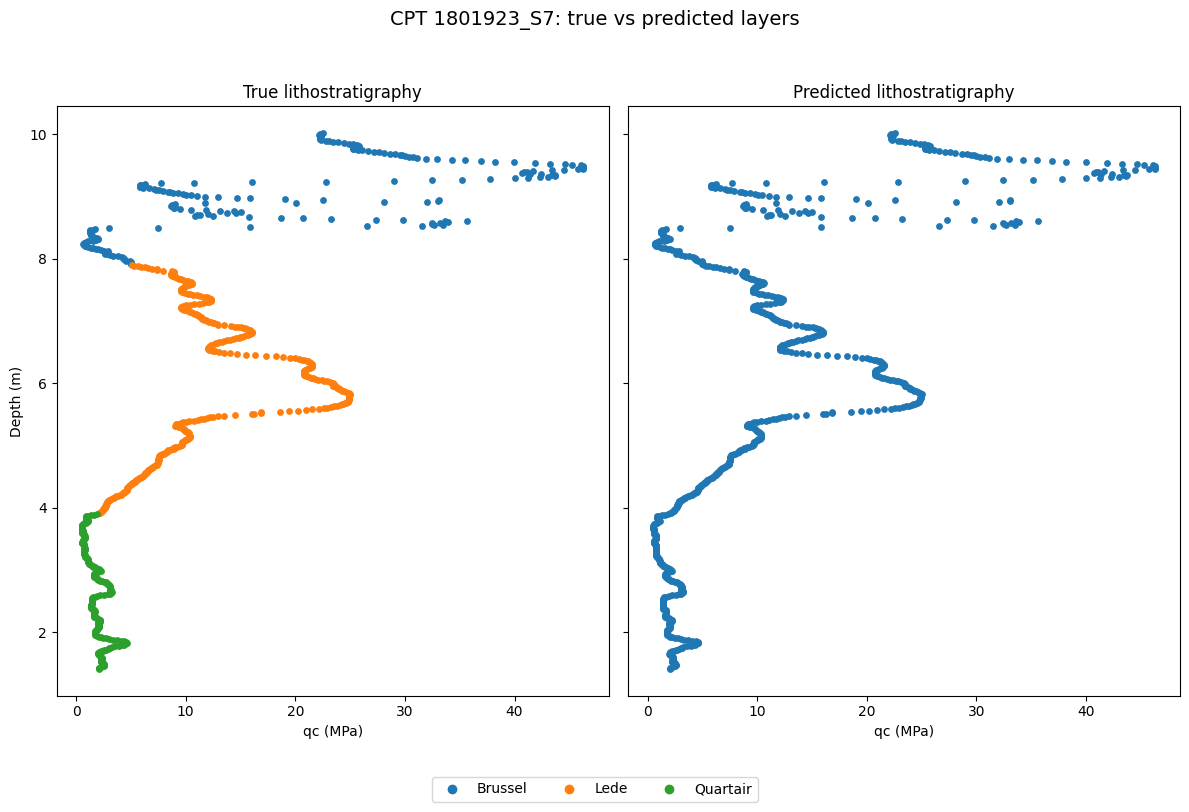

In [66]:
example_cpt = df_known[cpt_col].iloc[0]
profile_df = predict_cpt_profile(example_cpt, df_known, best_crf, cpt_col, depth_col)

plot_cpt_true_vs_pred_with_legend(profile_df, example_cpt, depth_col=depth_col)
